In [3]:
# !rm -rf ERA-V1
# !git clone https://github.com/selvaraj-sembulingam/ERA-V1.git
%cd ERA-V1/Assignments/S13/
# !git pull

/notebooks/ERA-V1/Assignments/S13/ERA-V1/Assignments/S13


In [4]:
!pip install -q pytorch_lightning grad-cam albumentations

In [5]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Training Started by Selvaraj Sembulingam


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]


Currently epoch 0
Train loss 22.24137306213379
On Train Eval loader:
On Train loader:
Class accuracy is: 32.511482%
No obj accuracy is: 65.863464%
Obj accuracy is: 28.528038%

Currently epoch 1
Train loss 12.789149284362793
On Train Eval loader:
On Train loader:
Class accuracy is: 34.812813%
No obj accuracy is: 97.474380%
Obj accuracy is: 20.547520%

Currently epoch 2
Train loss 11.117948532104492
On Train Eval loader:
On Train loader:
Class accuracy is: 38.818157%
No obj accuracy is: 97.985741%
Obj accuracy is: 26.343580%

Currently epoch 3
Train loss 10.04887580871582
On Train Eval loader:
On Train loader:
Class accuracy is: 40.624767%
No obj accuracy is: 95.118034%
Obj accuracy is: 49.215195%

Currently epoch 4
Train loss 9.337542533874512
On Train Eval loader:
On Train loader:
Class accuracy is: 36.647110%
No obj accuracy is: 97.418228%
Obj accuracy is: 38.188103%

Currently epoch 5
Train loss 8.708006858825684
On Train Eval loader:
On Train loader:
Class accuracy is: 42.792812%
N

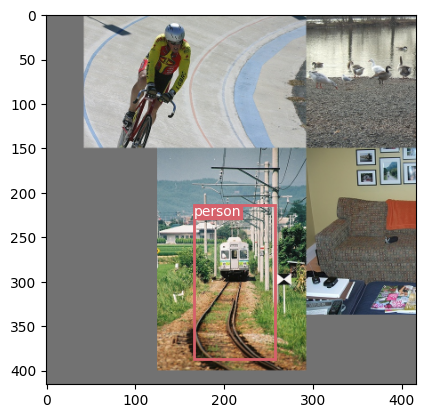

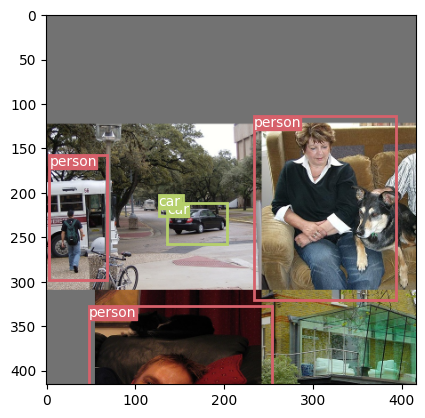

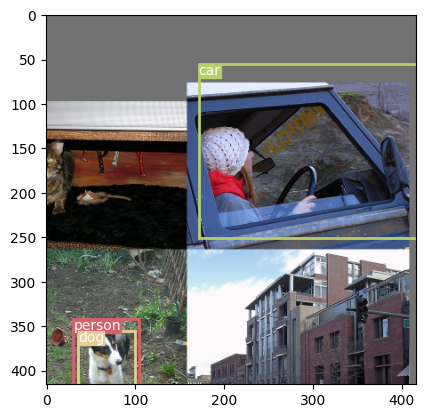

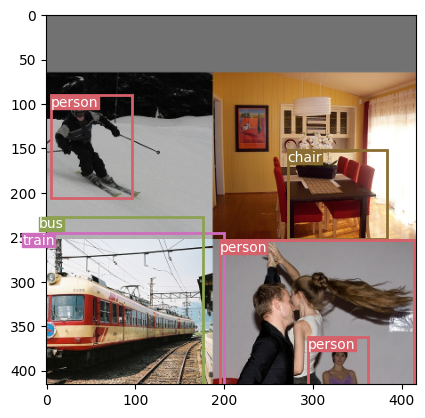

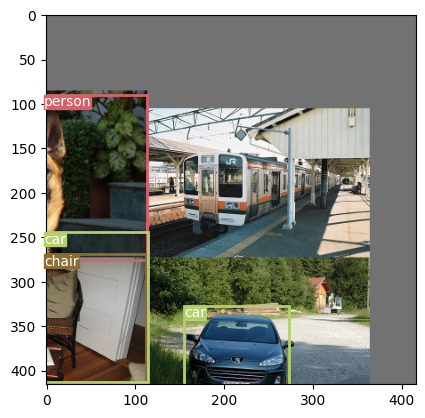

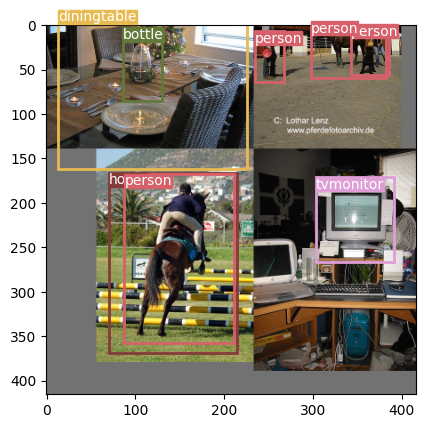

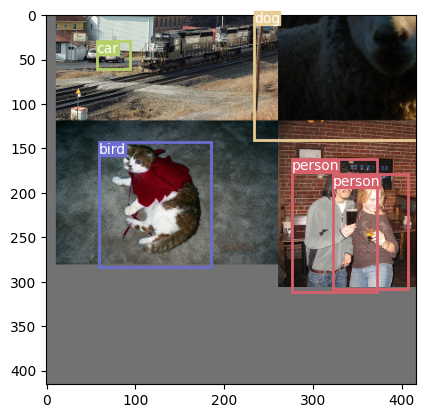

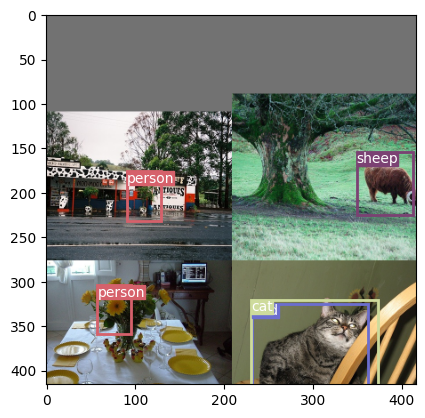


Currently epoch 10
Train loss 7.01668643951416
On Train Eval loader:
On Train loader:
Class accuracy is: 56.626766%
No obj accuracy is: 96.757332%
Obj accuracy is: 65.731270%

Currently epoch 11
Train loss 6.8323516845703125
On Train Eval loader:
On Train loader:
Class accuracy is: 61.416389%
No obj accuracy is: 98.070000%
Obj accuracy is: 57.604034%

Currently epoch 12
Train loss 6.663926124572754
On Train Eval loader:
On Train loader:
Class accuracy is: 63.585617%
No obj accuracy is: 97.205132%
Obj accuracy is: 65.439537%

Currently epoch 13
Train loss 6.478756904602051
On Train Eval loader:
On Train loader:
Class accuracy is: 62.620209%
No obj accuracy is: 97.314377%
Obj accuracy is: 67.610054%

Currently epoch 14
Train loss 6.342716693878174
On Train Eval loader:
On Train loader:
Class accuracy is: 63.363369%
No obj accuracy is: 97.488998%
Obj accuracy is: 65.206924%

Currently epoch 15
Train loss 6.185853481292725
On Train Eval loader:
On Train loader:
Class accuracy is: 59.94664

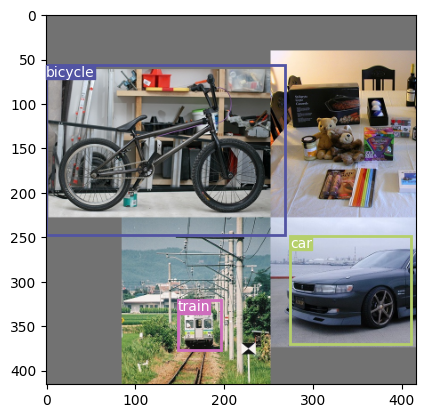

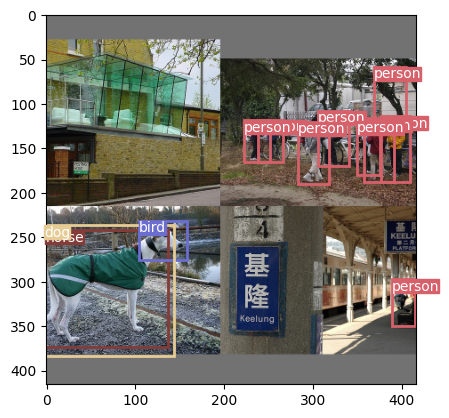

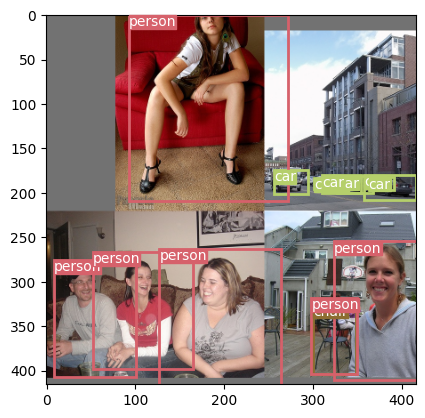

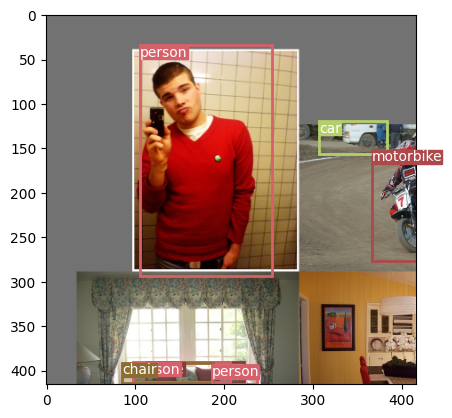

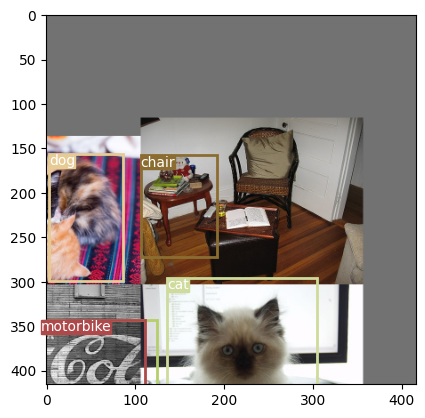

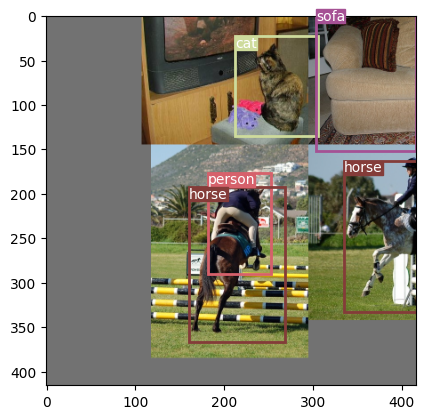

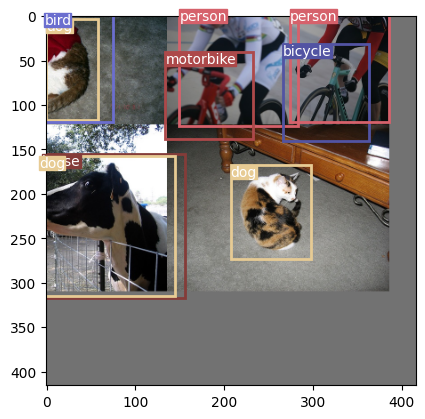

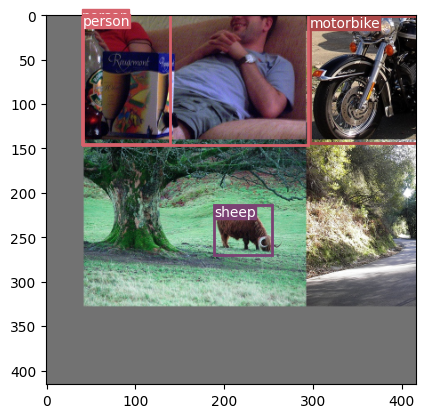


Currently epoch 20
Train loss 5.420825004577637
On Train Eval loader:
On Train loader:
Class accuracy is: 71.285690%
No obj accuracy is: 97.429398%
Obj accuracy is: 72.346649%

Currently epoch 21
Train loss 5.314687252044678
On Train Eval loader:
On Train loader:
Class accuracy is: 71.125092%
No obj accuracy is: 97.758766%
Obj accuracy is: 70.391479%

Currently epoch 22
Train loss 5.149376392364502
On Train Eval loader:
On Train loader:
Class accuracy is: 73.245712%
No obj accuracy is: 97.903748%
Obj accuracy is: 69.586082%

Currently epoch 23
Train loss 5.007915019989014
On Train Eval loader:
On Train loader:
Class accuracy is: 74.870911%
No obj accuracy is: 97.886314%
Obj accuracy is: 70.646820%

Currently epoch 24
Train loss 4.858802795410156
On Train Eval loader:
On Train loader:
Class accuracy is: 76.433449%
No obj accuracy is: 97.781960%
Obj accuracy is: 73.231285%

Currently epoch 25
Train loss 4.758069038391113
On Train Eval loader:
On Train loader:
Class accuracy is: 77.41662

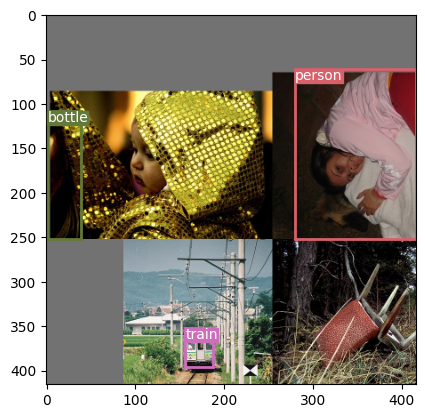

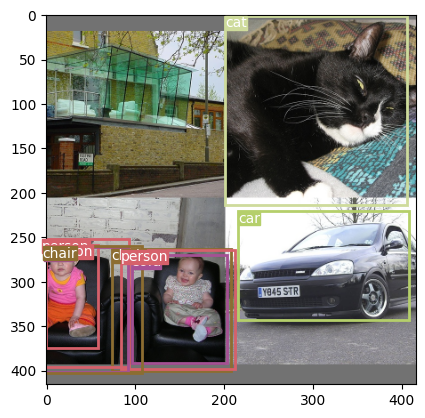

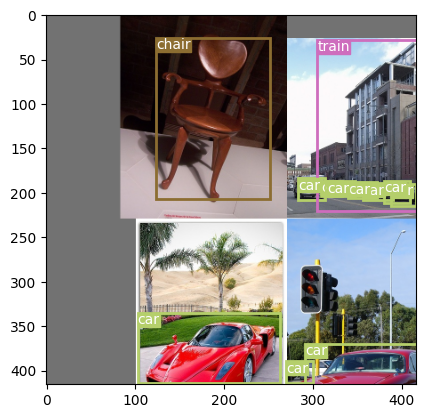

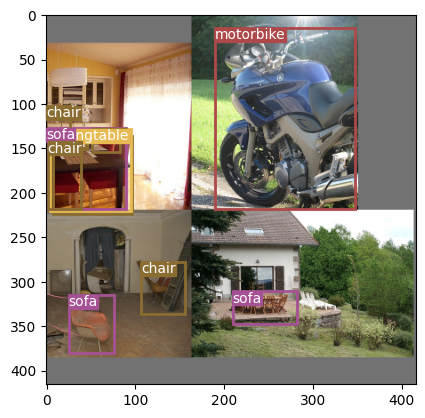

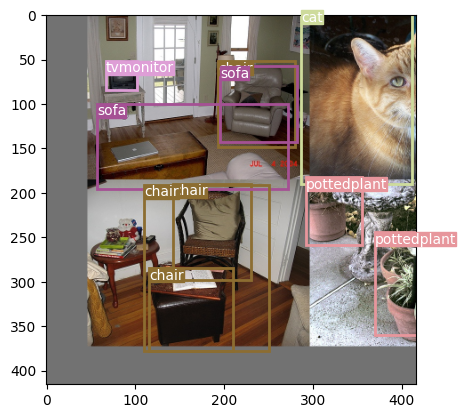

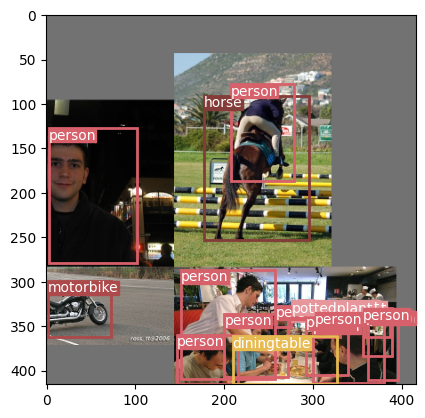

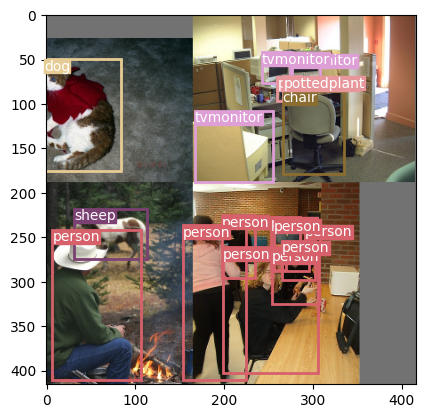

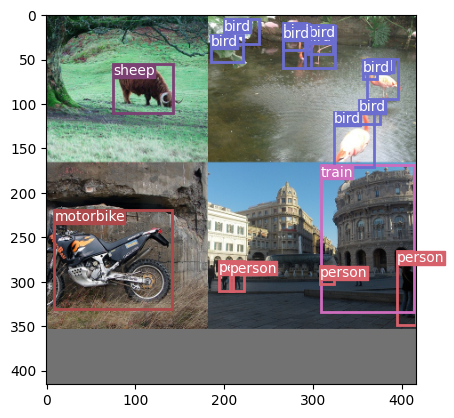


Currently epoch 30
Train loss 4.109917640686035
On Train Eval loader:
On Train loader:
Class accuracy is: 82.525284%
No obj accuracy is: 97.819695%
Obj accuracy is: 78.557274%

Currently epoch 31
Train loss 3.9779574871063232
On Train Eval loader:
On Train loader:
Class accuracy is: 83.191727%
No obj accuracy is: 97.931854%
Obj accuracy is: 77.405754%

Currently epoch 32
Train loss 3.828509569168091
On Train Eval loader:
On Train loader:
Class accuracy is: 84.604195%
No obj accuracy is: 97.922585%
Obj accuracy is: 79.040825%

Currently epoch 33
Train loss 3.704674482345581
On Train Eval loader:
On Train loader:
Class accuracy is: 85.557388%
No obj accuracy is: 97.978790%
Obj accuracy is: 79.425034%

Currently epoch 34
Train loss 3.597022771835327
On Train Eval loader:
On Train loader:
Class accuracy is: 85.991203%
No obj accuracy is: 98.031494%
Obj accuracy is: 80.060860%

Currently epoch 35
Train loss 3.4740614891052246
On Train Eval loader:
On Train loader:
Class accuracy is: 87.482

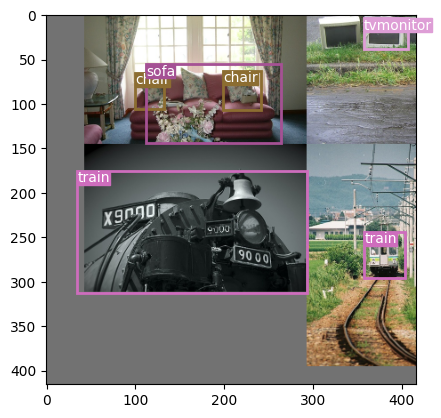

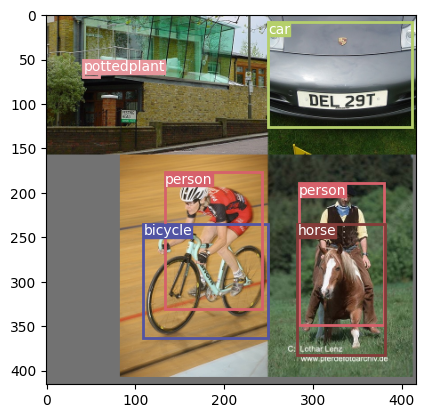

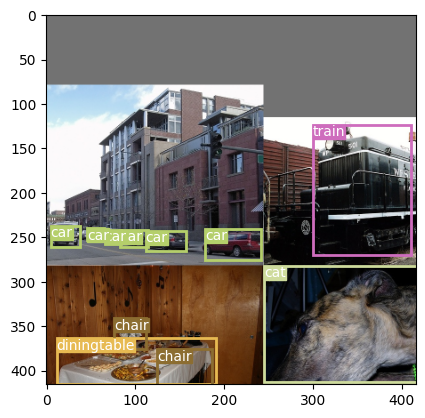

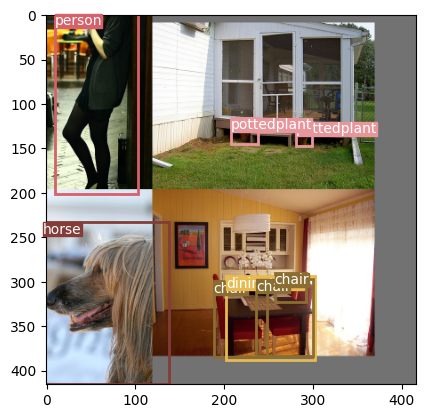

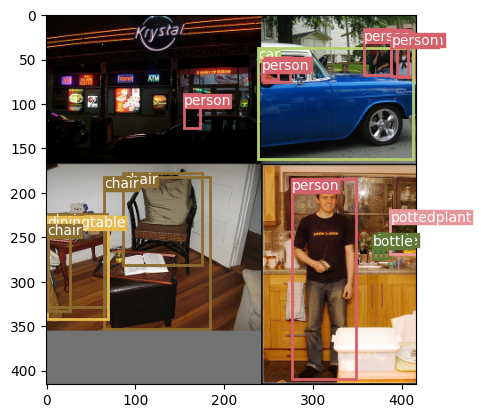

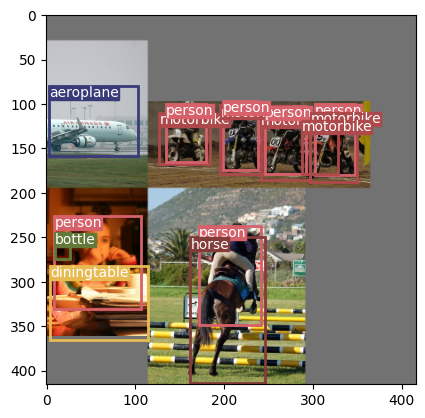

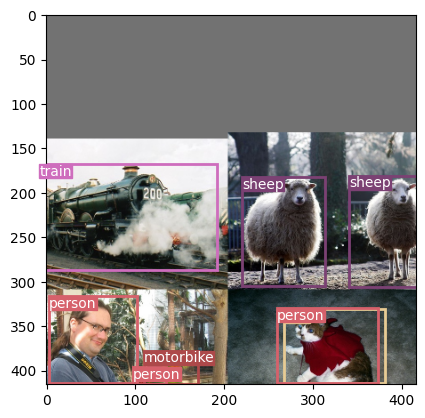

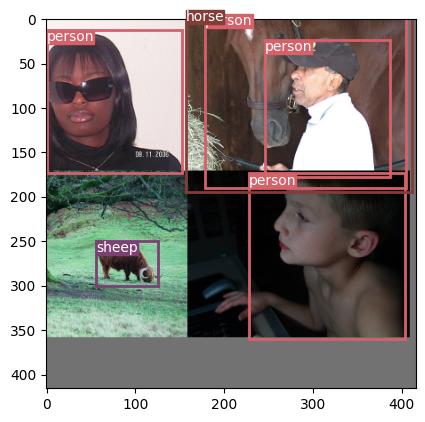

Class accuracy is: 84.319382%
No obj accuracy is: 98.226341%
Obj accuracy is: 76.665375%
MAP: 0.5284217000007629


`Trainer.fit` stopped: `max_epochs=40` reached.


In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch.optim.lr_scheduler import OneCycleLR

class YOLOv3Lightning(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = YOLOv3(num_classes=config.NUM_CLASSES)
        self.loss_fn = YoloLoss()
        self.scaled_anchors = (
            torch.tensor(config.ANCHORS)
            * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
        ).to(config.DEVICE)
        self.train_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )
        out = self(x)
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0])
                + self.loss_fn(out[1], y1, self.scaled_anchors[1])
                + self.loss_fn(out[2], y2, self.scaled_anchors[2])
        )
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)  # Logging the training loss for visualization
        self.train_step_outputs.append(loss)
        return loss
    
    def on_train_epoch_end(self):
        print(f"\nCurrently epoch {self.current_epoch}")
        train_epoch_average = torch.stack(self.train_step_outputs).mean()
        self.train_step_outputs.clear()
        print(f"Train loss {train_epoch_average}")
        print("On Train Eval loader:")
        print("On Train loader:")
        class_accuracy, no_obj_accuracy, obj_accuracy = check_class_accuracy(self.model, self.train_loader, threshold=config.CONF_THRESHOLD)
        self.log("class_accuracy", class_accuracy, on_epoch=True, prog_bar=True, logger=True) 
        self.log("no_obj_accuracy", no_obj_accuracy, on_epoch=True, prog_bar=True, logger=True) 
        self.log("obj_accuracy", obj_accuracy, on_epoch=True, prog_bar=True, logger=True) 
        
        if (self.current_epoch>0) and ((self.current_epoch+1) % 10 == 0):
            plot_couple_examples(self.model, self.test_loader, 0.6, 0.5, self.scaled_anchors)
        
        if (self.current_epoch>0) and (self.current_epoch+1 == 40):
            check_class_accuracy(self.model, self.test_loader, threshold=config.CONF_THRESHOLD)
            pred_boxes, true_boxes = get_evaluation_bboxes(
                self.test_loader,
                self.model,
                iou_threshold=config.NMS_IOU_THRESH,
                anchors=config.ANCHORS,
                threshold=config.CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            
            self.log("MAP", mapval.item(), on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY,
        )
        
        self.trainer.fit_loop.setup_data()
        dataloader = self.trainer.train_dataloader
        
        EPOCHS = config.NUM_EPOCHS
        lr_scheduler = OneCycleLR(
            optimizer,
            max_lr=1E-3,
            steps_per_epoch=len(dataloader),
            epochs=EPOCHS,
            pct_start=5/EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

        scheduler = {"scheduler": lr_scheduler, "interval" : "step"}

        return [optimizer], [scheduler]
    
    def setup(self, stage=None):
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
            train_csv_path=self.config.DATASET + "/train.csv",
            test_csv_path=self.config.DATASET + "/test.csv",
        )

    def train_dataloader(self):
        return self.train_loader
    
    def val_dataloader(self):
        return self.train_eval_loader
    
    def test_dataloader(self):
        return self.test_loader


if __name__ == "__main__":
    
    model = YOLOv3Lightning(config)
    
    checkpoint = ModelCheckpoint(filename='last_epoch', save_last=True)
    lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")
    trainer = pl.Trainer(
                  max_epochs=config.NUM_EPOCHS,
                  deterministic=True,
                  logger=True,
                  callbacks=[lr_rate_monitor],
                  enable_model_summary=False,
                  log_every_n_steps=1,
                  precision=16
              )
    print("Training Started by Selvaraj Sembulingam")
    trainer.fit(model)
    torch.save(model.state_dict(), 'YOLOv3.pth')


In [8]:
print("Training Successful")

Training Successful


In [16]:
!ls

README.md    config.py	 lightning_logs  main.ipynb  train.py
__pycache__  dataset.py  loss.py	 model.py    utils.py


In [25]:
!zip -r lightning_logs.zip lightning_logs/*

updating: lightning_logs/version_0/ (stored 0%)
updating: lightning_logs/version_0/events.out.tfevents.1691514606.naiv5cumgq.3642.0 (deflated 5%)
updating: lightning_logs/version_1/ (stored 0%)
updating: lightning_logs/version_1/hparams.yaml (stored 0%)
updating: lightning_logs/version_1/events.out.tfevents.1691514650.naiv5cumgq.3642.1 (deflated 10%)
updating: lightning_logs/version_2/ (stored 0%)
updating: lightning_logs/version_2/hparams.yaml (stored 0%)
updating: lightning_logs/version_2/events.out.tfevents.1691514753.naiv5cumgq.3642.2 (deflated 11%)
updating: lightning_logs/version_3/ (stored 0%)
updating: lightning_logs/version_3/hparams.yaml (stored 0%)
updating: lightning_logs/version_3/events.out.tfevents.1691514779.naiv5cumgq.3642.3 (deflated 10%)
updating: lightning_logs/version_4/ (stored 0%)
updating: lightning_logs/version_4/hparams.yaml (stored 0%)
updating: lightning_logs/version_4/events.out.tfevents.1691514799.naiv5cumgq.3642.4 (deflated 68%)


In [26]:
!ls -lh

total 654M
-rw-r--r-- 1 root root   10 Aug  8 16:08 README.md
drwxr-xr-x 2 root root    5 Aug  8 17:10 __pycache__
-rw-r--r-- 1 root root 2.8K Aug  8 16:08 config.py
-rw-r--r-- 1 root root 7.2K Aug  8 16:08 dataset.py
drwxr-xr-x 8 root root    6 Aug  8 17:30 lightning_logs
-rw-r--r-- 1 root root 653M Aug  8 17:53 lightning_logs.zip
-rw-r--r-- 1 root root 2.8K Aug  8 16:08 loss.py
-rw-r--r-- 1 root root 1.1M Aug  8 16:08 main.ipynb
-rw-r--r-- 1 root root 5.4K Aug  8 16:08 model.py
-rw-r--r-- 1 root root 3.5K Aug  8 16:08 train.py
-rw-r--r-- 1 root root  21K Aug  8 16:08 utils.py


In [23]:
!ls lightning_logs/version_4/checkpoints

'epoch=39-step=40.ckpt'


In [29]:
!du -sh lightning_logs/version_4/

10K	lightning_logs/version_4/
